In [1]:
import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

# Deep Learning Final Project 

For this deep learning assignment, we will utilize the Letter Recognition dataset from the UC Irvine Machine Learning Repository.

The objective of this project is to design and train a deep neural network capable of accurately classifying letters of the English alphabet based on a set of extracted features. Each sample in the dataset corresponds to a specific letter and is represented by 16 numerical attributes, which describe various statistical characteristics derived from the letter’s pixel representation.

The dataset, along with a detailed description of its features, can be accessed at the following link:

https://archive.ics.uci.edu/dataset/59/letter+recognition

In [2]:

df = pd.read_csv('data/letter-recognition.data')

df.columns = ["target", "x-box", "y-box", "width", "high", "oxpix", "x-bar", "y-bar", "x2bar", "y2bar", "xybar", "x2ybr", "xy2br", "x-ege", "xegvy", "y-ege", "yegvx"]

### Features

As previously mentioned, each sample in the dataset is characterized by **16 features**. These features capture various primitive numerical attributes related to the physical properties of each letter, such as geometric and statistical measurements derived from the letter’s pixel-based image representation.

In [3]:
df.head()

,target,x-box,y-box,width,high,oxpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
1,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
2,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
3,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
4,S,4,11,5,8,3,8,8,6,9,5,6,6,0,8,9,7


# Exploratory Data Analysis (EDA)

### Feature Distributions

We will begin by analyzing the dataset to understand its underlying properties and to determine whether any preprocessing or normalization steps are necessary prior to model training.

Our first step is to visualize the distribution of each feature.  
Assessing the distributions helps identify characteristics such as skewness, outliers, or deviations from normality, all of which can influence the performance of deep learning models, particularly when using optimization algorithms that assume certain input properties.

As shown in the plots below, most features appear to follow an approximately normal distribution, although some variations and skewed distributions are also observed. These findings will inform any decisions regarding feature scaling or transformation in subsequent steps.

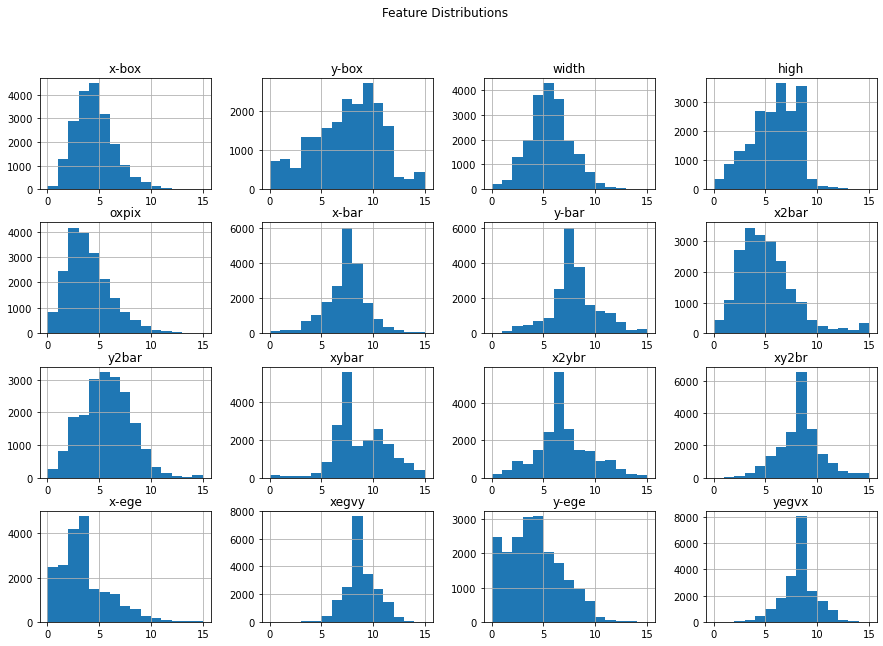

In [4]:
df.iloc[:, 1:].hist(figsize=(15, 10), bins=15)
plt.suptitle('Feature Distributions')
plt.show()

### Feature Correlation Matrix

Next, we will examine the correlation between features to identify potential redundancies or dependencies within the dataset.

The feature correlation matrix shown below reveals that certain features — particularly **x-box**, **y-box**, **width**, **height**, and **onpix** — exhibit strong positive correlations with one another.

High feature correlation is generally undesirable for training deep learning models, as it can introduce redundancy, reduce model generalization, and unnecessarily increase the complexity of the learning process. 

It may be beneficial to apply dimensionality reduction techniques or feature selection methods to address this issue.

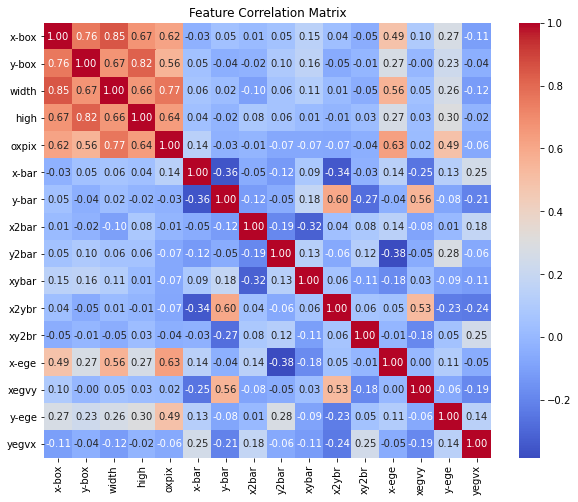

In [5]:
correlation_matrix = df.iloc[:, 1:].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Matrix')
plt.show()

### Data Cleaning

To address the issue of multicollinearity identified in the correlation analysis, we will remove several highly correlated features.  
Specifically, we will drop **y-box**, **width**, **height**, and **onpix**, while retaining **x-box** to preserve positional information about the letters.

By eliminating redundant features, we aim to reduce the complexity of the model, improve training efficiency, and enhance the model’s ability to generalize to unseen data.

In [6]:
df_clean = df.drop(columns=["y-box","width","high","oxpix"])

After removing the selected features, the updated correlation matrix shows minimal correlation between the remaining features.  

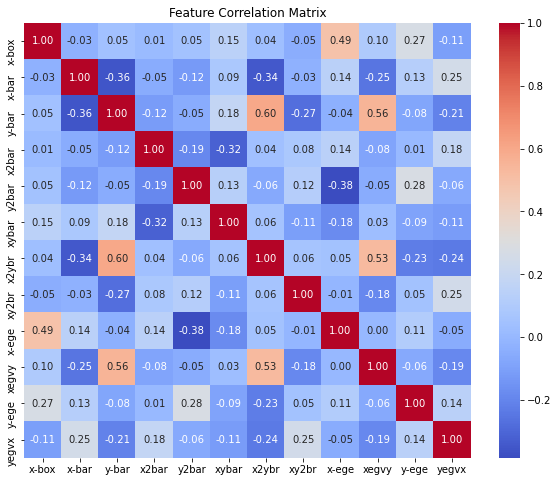

In [7]:
# Compute correlation matrix
correlation_matrix = df_clean.iloc[:, 1:].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Matrix')
plt.show()

# Model Architecture

We will now train a neural network (NN) model to classify each letter based on the refined set of features selected during data preprocessing.  
The model architecture is based on a **feedforward neural network**, which is well-suited for structured datasets like this one.

### Model Dimensions

The architecture consists of an input layer, two hidden layers, and an output layer, structured as follows:

| Layer              | Input Shape               | Output Shape              |
|:-------------------|:---------------------------|:---------------------------|
| Input              | (batch_size, input_size)    | (batch_size, input_size)    |
| Linear (hidden1)   | (batch_size, input_size)    | (batch_size, hidden_size)   |
| Activation (act1)  | (batch_size, hidden_size)   | (batch_size, hidden_size)   |
| Linear (hidden2)   | (batch_size, hidden_size)   | (batch_size, hidden_size)   |
| Activation (act2)  | (batch_size, hidden_size)   | (batch_size, hidden_size)   |
| Linear (output)    | (batch_size, hidden_size)   | (batch_size, 26)            |
| Output             | (batch_size, 26)            | (batch_size, 26)            |

Here, **input_size** corresponds to the number of features after cleaning, **hidden_size** refers to the number of neurons in each hidden layer, and the output dimension **26** corresponds to the 26 letters of the English alphabet.

Using two hidden layers provides the model with additional representational capacity.

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim


class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation = nn.ReLU()):
        super(FeedForwardNN, self).__init__()

        self.hidden1 = nn.Linear(input_size, hidden_size) 
        self.act1 = activation 

        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.act2 = activation 

        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):


        x = self.hidden1(x) 
        x = self.act1(x) 

        x = self.hidden2(x) 
        x = self.act2(x) 

        x = self.output(x)  

        return x


def train(X_train,X_train_tensor,y_train_tensor,hidden_layer,learning_rate=0.01,epochs=100, activation=nn.ReLU()):
    input_size = X_train.shape[1]  
    hidden_size = hidden_layer
    output_size = 26 

    model = FeedForwardNN(input_size, hidden_size, output_size, activation=activation)

    criterion = nn.CrossEntropyLoss()


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = epochs
    for epoch in range(num_epochs):
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    return model

def train_logreg(X_train,y_train,max_iterations):

    logreg = LogisticRegression(max_iter=max_iterations)
    logreg.fit(X_train, y_train)

    return logreg



def predict(model, x_test):

    model.eval()
    with torch.no_grad():
        predictions = torch.argmax(model(x_test), dim=1)

    return predictions

def test(model,X_test_tensor,y_test_tensor):

    with torch.no_grad():
        model.eval()
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)  
        correct = (predicted == y_test_tensor).sum().item()
        accuracy = correct / len(y_test_tensor)

        return accuracy



### Training

Before initiating the training process, we perform several important preprocessing steps:

- **Feature Selection and Scaling:**  
  We drop the previously identified highly correlated features and scale the remaining features using a **StandardScaler**. Scaling ensures that all features contribute equally to the model’s learning process and helps improve convergence during training.

- **Train-Test Split:**  
  The dataset is split into **70% training data** and **30% test data** to allow for model evaluation on unseen samples.

- **Label Encoding:**  
  Since the labels are originally categorical (letters 'A', 'B', 'C', etc.), we map each letter to a corresponding numerical integer using Python’s built-in `ord()` function.

- **Tensor Conversion:**  
  The training and test datasets are converted into **Tensors** to be compatible with the model input requirements.

These preprocessing steps ensure that the data is appropriately prepared for effective ingestion and training by the neural network.

In [20]:

df_clean = df.drop(columns=["y-box","width","high","oxpix"])
df_clean['target'] = df_clean['target'].apply(lambda x: ord(x) - ord('A'))


X = df_clean.iloc[:, 1:].values  # Features (16 columns)
y = df_clean.iloc[:, 0].values   # Labels (A-Z)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


### Initial Model Results


The model demonstrates strong initial performance, achieving an accuracy of approximately **86%** on test data.

This result indicates that the network is already able to capture meaningful patterns within the feature space, suggesting that the chosen architecture and preprocessing pipeline are effective. We can further improve this result with hyperparameter tuning

In [52]:
nn_model = train(X_train,X_train_tensor,y_train_tensor,hidden_layer=100,epochs=50,learning_rate=0.01, activation=nn.LeakyReLU())
acc = test(nn_model,X_test_tensor,y_test_tensor)


print("Test Accuracy: {:.2f}%".format(acc * 100))

Test Accuracy: 85.98%


### Comparison to Logistic Regression Model

To better understand our model's performance, we will compare it against a simpler **Logistic Regression** model as baseline.   

Logistic Regression is computationally efficient and often serves as a strong benchmark for classification tasks involving structured data.

In this case, the Logistic Regression model performs significantly worse than our neural network model, achieving noticeably lower test accuracy.  

In [56]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


print("Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Test Accuracy: 73.32%


### Confusion Matrix

To gain deeper insight into the performance of each model, we will examine and compare their respective **confusion matrices**.

The confusion matrix provides a detailed breakdown of the model’s classification performance across all classes, highlighting which letters are correctly classified and where the most common misclassifications occur.

Looking at our matricies, it is evident that the neural network model is significantly more accurate in distinguishing between similar-looking letters, particularly those with overlapping feature profiles.  

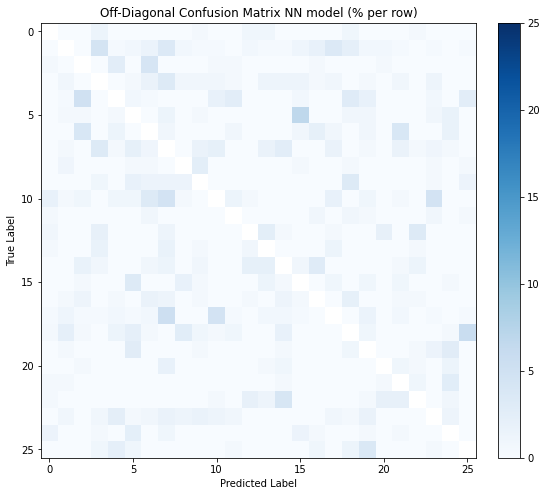

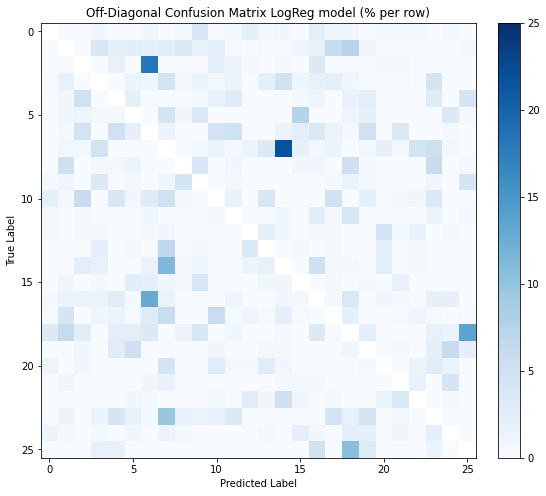

In [48]:
from sklearn.metrics import  confusion_matrix
import numpy as np


y_pred_nn = predict(model=nn_model,x_test=X_test_tensor)
y_pred_logreg = logreg.predict(X_test)

cm_nn = confusion_matrix(y_pred_nn,y_test)
cm_logreg = confusion_matrix(y_pred_logreg,y_test)

def draw_confusionm(cm,modeltye):
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    np.fill_diagonal(cm_percent, np.nan) 

    plt.figure(figsize=(10, 8))
    im = plt.imshow(cm_percent, interpolation='nearest', cmap='Blues', vmin=0, vmax=25)

    plt.title("Off-Diagonal Confusion Matrix {} model (% per row)".format(modeltye))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.colorbar(im, fraction=0.046, pad=0.04)


draw_confusionm(cm_nn,"NN")
draw_confusionm(cm_logreg,"LogReg")


## Hyperparameter Optimization with Grid Search

While our initial neural network model already outperforms the baseline Logistic Regression model, there is potential to further enhance its performance through hyperparameter tuning.

To achieve this, we will employ a **grid search** strategy to perform an exhaustive search a predefined set of hyperparameter combinations.  

In [54]:
import itertools

def grid_search(X_train, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    hidden_layer_options = [100, 150, 200]
    epoch_options = [50,100]
    learning_rate_options = [0.001, 0.01]
    activation_options = [nn.ReLU(), nn.LeakyReLU()]

    best_score = float('-inf')
    best_params = None

    param_grid = itertools.product(hidden_layer_options, epoch_options, learning_rate_options, activation_options)

    for hidden_layer, epochs, learning_rate, activation in param_grid:
        #print(f"Training with hidden_layer={hidden_layer}, epochs={epochs}, learning_rate={learning_rate}, activation={activation.__class__.__name__}")

        model = train(
            X_train, 
            X_train_tensor, 
            y_train_tensor, 
            hidden_layer=hidden_layer, 
            epochs=epochs, 
            learning_rate=learning_rate, 
            activation=activation
        )

        
        score = test(model,X_test_tensor,y_test_tensor)

        #print(f"Score: {score:.4f}")

        if score > best_score:
            best_score = score
            best_params = {
                'hidden_layer': hidden_layer,
                'epochs': epochs,
                'learning_rate': learning_rate,
                'activation': activation
            }

    return best_params,best_score



### Optimized Hyperparameters

The grid search process resulted in a set of optimized hyperparameters that significantly improved the model’s performance.  
With these new settings, the neural network achieves **95% accuracy** on the test set, a substantial improvement compared to the initial model.

In [57]:
best_params,best_score = grid_search(X_train, X_train_tensor, y_train_tensor,X_test_tensor,y_test_tensor)
print(best_params)

print("Test Accuracy: {:.2f}%".format(best_score * 100))

{'hidden_layer': 200, 'epochs': 100, 'learning_rate': 0.01, 'activation': LeakyReLU(negative_slope=0.01)}
Test Accuracy: 95.03%


# Conclusion

The neural network model has proven capable of solving the letter classification task with a high level of accuracy.  

However, the improved performance comes at the cost of increased computational requirements.  
Training the neural network — particularly with the inclusion of **Grid Search** for hyperparameter optimization — required significantly more computational resources compared to training the Logistic Regression model.  